# Кредитный скоринг банков

##### Задача кредитного скоринга является одной из самых распространенных задач машинного обучения. Модели для решения этой задачи находят применение в банковском и денежно-финансовом секторах. 


## Сбор и обработка данных

##### В этой работе рассмотрены данные по российским банкам с информационной базы СПАРК. Для построения модели, использовались месячные данные с 2013-2017 гг. Данные включают 470 действующих банков и 57 – в состоянии банкротства.Также, в базе есть 1010 недействующих банков, из которых было отобраны банки, которые ликвидировались по причине банкротства (81 банк).

### Соединение файлов.

##### Спарк накладывает ограничения на размер скачеваемых файлов. Поэтому данные были скачены частями, а далее объединялись в один файл. Код объединения файлов можно посмотреть в каждой из папок. 

In [2]:
import pandas as pd
import numpy as np

In [2]:
acting = pd.read_csv('acting.csv', sep=';', index_col=0, low_memory=False)
bankruptcy = pd.read_csv('bankruptcy.csv', sep=';', index_col=0, low_memory=False)
liquidation = pd.read_csv('liquidation.csv', sep=';', index_col=0, low_memory=False)
inacting = pd.read_csv('liquidation.csv', sep=';', index_col=0, low_memory=False)

### Панельный вид.

##### На следующем этапе нужно из 1010 недействующих банков оставить только те, которые обанкротились, так как в данные были включены банки, которые были закрыты по другим причинам.

In [57]:
inacting = inacting[(inacting['Важная информация'].notnull()) & (inacting['Важная информация'].str.contains('вследствие банкротства '))]

##### Для удобства скачивания файлов были включены частично 2012 и 2019 года. Но так как они не использовались для построения моделей, они были удалены.

In [59]:
data = [bankruptcy, liquidation, acting, inacting]
for df in data:
    df = df[df.columns.drop(list(df.filter(regex='2012')))]
    df = df[df.columns.drop(list(df.filter(regex='2019')))]

In [60]:
acting.head(5)

№           Наименование  Регистрационный номер  \
0  1                 ВЭБ.РФ                  964.0   
1  2         БАНК ВТБ (ПАО)                 1000.0   
2  3     РОССЕЛЬХОЗБАНК, АО                 3349.0   
3  4  ФК ОТКРЫТИЕ, ПАО БАНК                 2209.0   
4  5          БАНК ГПБ (АО)                  354.0   

                                 Наименование полное  \
0       ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ РАЗВИТИЯ "ВЭБ.РФ"   
1          БАНК ВТБ (ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО)   
2  АКЦИОНЕРНОЕ ОБЩЕСТВО "РОССИЙСКИЙ СЕЛЬСКОХОЗЯЙС...   
3  ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО БАНК "ФИНАНСОВА...   
4               "ГАЗПРОМБАНК" (АКЦИОНЕРНОЕ ОБЩЕСТВО)   

                            Адрес (место нахождения)  \
0  107078, г. Москва, проспект Академика Сахарова...   
1  190000, г. Санкт-Петербург, ул. Большая Морска...   
2  119034, г. Москва, пер. Гагаринский, д. 3(Бизн...   
3   115114, г. Москва, ул. Летниковская, д. 2 стр. 4   
4    117420, г. Москва, ул. Намёткина, д. 16 корп. 1   

             Руководитель ФИО Дата регистрации Возраст банка  Дата ликвидации  \
0      Шувалов Игорь Иванович       22.12.1993          25,0              NaN   
1    Костин Андрей Леонидович       17.10.1990          28,0              NaN   
2       Листов Борис Павлович       24.04.2000          18,5              NaN   
3  Задорнов Михаил Михайлович       15.12.1992          26,0              NaN   
4      Акимов Андрей Игоревич       13.11.2001          17,0              NaN   

        Статус                             ...                               \
0  Действующая                             ...                                
1  Действующая                             ...                                
2  Действующая                             ...                                
3  Действующая                             ...                                
4  Действующая                             ...                                

   2018 - 4мес., Рентабельность собственного капитала (ROE), %  \
0                                             -2,91%             
1                                             11,04%             
2                                              2,51%             
3                                             19,81%             
4                                             -0,52%             

  2018 - 5мес., Рентабельность собственного капитала (ROE), %  \
0                                             -4,20%            
1                                             10,70%            
2                                              2,39%            
3                                             17,99%            
4                                             -0,65%            

  2018 - 6мес., Рентабельность собственного капитала (ROE), %  \
0                                             -5,45%            
1                                             10,18%            
2                                              2,33%            
3                                             16,06%            
4                                             -0,78%            

  2018 - 7мес., Рентабельность собственного капитала (ROE), %  \
0                                             -6,83%            
1                                              9,51%            
2                                              2,30%            
3                                             13,88%            
4                                             -0,86%            

  2018 - 8мес., Рентабельность собственного капитала (ROE), %  \
0                                             -8,21%            
1                                              8,89%            
2                                              2,24%            
3                                             11,53%            
4                                             -0,98%            

  2018 - 9мес., Рентабельность собственного капитала (ROE), %  \
0               

In [35]:
def panel(df):
    def get_panel_col_names(df):
        panel_col_names, panel_col_names_full = {}, []
        for col in list(df):
            try:
                if int(col.split(',')[0].split(' - ')[0]):
                    cur_col_name = ','.join(col.split(',')[1:]).lstrip()
                    panel_col_names[cur_col_name] = panel_col_names.get(cur_col_name, [])
                    panel_col_names[cur_col_name].append(col)
                    panel_col_names_full.append(col)
            except ValueError:
                pass
        return panel_col_names, panel_col_names_full
    
    panel_col_names, panel_col_names_full = get_panel_col_names(df)
    non_panel_col_names = [col for col in list(df) if col in (set(df) - set(panel_col_names_full))]

    new_dict = {col: [] for col in ['index', 'year', 'month'] + non_panel_col_names + list(panel_col_names)}
    for index, company in enumerate(df['Наименование полное']):
        if index % 10 == 0:
            print(index)
        for year in range(2013, 2019):
            for month in range(1, 13):
                new_dict['year'].append(year) 
                new_dict['index'].append(index)
                new_dict['month'].append(month) 
            
                for col in non_panel_col_names:
                    new_dict[col].append(list(df[(df['Наименование полное'] == company)][col])[0])

                for col in panel_col_names.keys():
                    full_col_name = None
                    for c in panel_col_names[col]:
                        if str(year) in c and str(month) in c:
                            full_col_name = c
                    if full_col_name:
                        new_dict[col].append(list(df[(df['Наименование полное'] == company)][full_col_name])[0])
                    else:
                        print(year, col)
                    
                    
    return new_dict


In [ ]:
panel_bankruptcy = pd.DataFrame(panel(bankruptcy))

In [ ]:
panel_acting = pd.DataFrame(panel(acting))

In [ ]:
panel_inacting = pd.DataFrame(panel(inacting))

In [ ]:
panel_liquidation = pd.DataFrame(panel(liquidation))

In [155]:
# Данные достаточно долго преобразуются. Поэтому дальше используются готовые данные.
panel_acting = pd.read_csv('panel_acting.csv', sep=';', low_memory=False, index_col=0)
panel_bankruptcy = pd.read_csv('panel_bankruptcy.csv', sep=';', low_memory=False, index_col=0)
panel_liquidation = pd.read_csv('panel_liquidation.csv', sep=';', low_memory=False, index_col=0)
panel_inacting = pd.read_csv('panel_inacting.csv', sep=';', low_memory=False, index_col=0)

##### Проверяем правильно ли обработались данные и удаляем лишние признаки.

In [4]:
print(f' Действующие {panel_acting.shape}\n Банкроты {panel_bankruptcy.shape}\n В состоянии ликвидации {panel_liquidation.shape}\n Недействующие {panel_inacting.shape}')

 Действующие (33840, 46)
 Банкроты (4104, 43)
 В состоянии ликвидации (24552, 45)
 Недействующие (5832, 45)


In [5]:
set(panel_acting)-set(panel_bankruptcy)

{'Unnamed: 0', 'Unnamed: 0.1', '№'}

In [6]:
set(panel_acting)-set(panel_liquidation)

{'Unnamed: 0'}

In [7]:
set(panel_inacting)-set(panel_bankruptcy)

{'Unnamed: 0.1', '№'}

In [156]:
del panel_acting['Unnamed: 0']
del panel_acting['Unnamed: 0.1']
del panel_acting['№']

del panel_inacting['Unnamed: 0.1']
del panel_inacting['№']

del panel_liquidation['Unnamed: 0.1']
del panel_liquidation['№']

In [9]:
print(f' Действующие {panel_acting.shape}\n Банкроты {panel_bankruptcy.shape}\n В состоянии ликвидации {panel_liquidation.shape}\n Недействующие {panel_inacting.shape}')

 Действующие (33840, 43)
 Банкроты (4104, 43)
 В состоянии ликвидации (24552, 43)
 Недействующие (5832, 43)


In [10]:
panel_acting.head(5)

year  month Наименование  Регистрационный номер  \
index                                                    
0      2013      1       ВЭБ.РФ                  964.0   
0      2013      2       ВЭБ.РФ                  964.0   
0      2013      3       ВЭБ.РФ                  964.0   
0      2013      4       ВЭБ.РФ                  964.0   
0      2013      5       ВЭБ.РФ                  964.0   

                                Наименование полное  \
index                                                 
0      ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ РАЗВИТИЯ "ВЭБ.РФ"   
0      ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ РАЗВИТИЯ "ВЭБ.РФ"   
0      ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ РАЗВИТИЯ "ВЭБ.РФ"   
0      ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ РАЗВИТИЯ "ВЭБ.РФ"   
0      ГОСУДАРСТВЕННАЯ КОРПОРАЦИЯ РАЗВИТИЯ "ВЭБ.РФ"   

                                Адрес (место нахождения)  \
index                                                      
0      107078, г. Москва, проспект Академика Сахарова...   
0      107078, г. Москва, проспект Академика Сахарова...   
0      107078, г. Москва, проспект Академика Сахарова...   
0      107078, г. Москва, проспект Академика Сахарова...   
0      107078, г. Москва, проспект Академика Сахарова...   

             Руководитель ФИО Дата регистрации Возраст банка  Дата ликвидации  \
index                                                                           
0      Шувалов Игорь Иванович       22.12.1993          25,0              NaN   
0      Шувалов Игорь Иванович       22.12.1993          25,0              NaN   
0      Шувалов Игорь Иванович       22.12.1993          25,0              NaN   
0      Шувалов Игорь Иванович       22.12.1993          25,0              NaN   
0      Шувалов Игорь Иванович       22.12.1993          25,0              NaN   

                           ...                       \
index                      ...                        
0                          ...                        
0                          ...                        
0                          ...                        
0                          ...                        
0                          ...                        

      Вклады физических лиц, RUB  Облигации, RUB Векселя, RUB  \
index                                                           
0                  1 431 438 000               0  403 540 000   
0                  1 431 438 000               0  403 540 000   
0                  1 431 438 000               0  403 540 000   
0                    820 042 000               0  290 439 000   
0                    897 103 000               0  200 610 000   

      Резервы на возможные потери, RUB Капитал, RUB  \
index                                                 
0                          227 779 000  735 693 000   
0                          227 779 000  735 693 000   
0                          227 779 000  735 693 000   
0                          127 714 000  554 607 000   
0                          130 547 000  563 402 000   

      Коэффициент покрытия Кредитного портфеля, %  \
index                                               
0                                           7,52%   
0                                           7,52%   
0                                           7,52%   
0                                           4,75%   
0                                           4,77%   

      Коэффициент обеспечения Кредитного портфеля, %  \
index                                                  
0                                            101,59%   
0                                            101,59%   
0                                            101,59%   
0                                             73,44%   
0                                             79,68%   

      Коэффициент просроченной задолженности в Кредитном портфеле, %  \
index                                                                  
0                                                  0,52%               
0               

##### Для анализа удобно использовать индексацию банков. Так как на этапе работы с пропусками будут удалены некоторые строки, проще индексацию проставить заранее. 

In [157]:
index_for_liquidation = [(i//72+58) for i in range(panel_liquidation.shape[0])]
index_for_acting = [(i//72+399) for i in range(panel_acting.shape[0])]
index_for_inacting =  [(i//72+869) for i in range(panel_inacting.shape[0])]
index_for_bankruptcy = [(i//72+1) for i in range(panel_bankruptcy.shape[0])] 

In [158]:
panel_bankruptcy['index'] = index_for_bankruptcy
panel_bankruptcy = panel_bankruptcy[["index"] + list(panel_bankruptcy)[:-1]]

panel_liquidation['index'] = index_for_liquidation
panel_liquidation = panel_liquidation[["index"] + list(panel_liquidation)[:-1]]

panel_acting['index'] = index_for_acting
panel_acting = panel_acting[["index"] + list(panel_acting)[:-1]]

panel_inacting['index'] = index_for_inacting
panel_inacting = panel_inacting[["index"] + list(panel_inacting)[:-1]]


### Обработка пропусков.

##### Данные скачивались без учета срока функционирования банков, поэтому нужно удалить те года, когда банки либо ещё не существовали, либо уже обанкротились. Дата ликвидации есть только у банков, которые были выделены из недействующих.

In [159]:
panel_bankruptcy['registration_year'] = panel_bankruptcy['Дата регистрации'].apply(lambda x: int(x.split('.')[2]))
panel_bankruptcy = panel_bankruptcy[panel_bankruptcy['year'] >= panel_bankruptcy['registration_year']]

panel_liquidation['registration_year'] = panel_liquidation['Дата регистрации'].apply(lambda x: int(x.split('.')[2]))
panel_liquidation = panel_liquidation[panel_liquidation['year'] >= panel_liquidation['registration_year']]

panel_acting['registration_year'] = panel_acting['Дата регистрации'].apply(lambda x: int(x.split('.')[2]))
panel_acting = panel_acting[panel_acting['year'] >= panel_acting['registration_year']]

panel_inacting['registration_year'] = panel_inacting['Дата регистрации'].apply(lambda x: int(x.split('.')[2]))
panel_inacting['liquidation_year'] = panel_inacting['Дата ликвидации'].apply(lambda x: int(x.split('.')[2]))
panel_inacting = panel_inacting[(panel_inacting['liquidation_year'] >= panel_inacting['year']) & (panel_inacting['year'] >= panel_inacting['registration_year'])]

del panel_inacting['registration_year']
del panel_inacting['liquidation_year']
del panel_bankruptcy['registration_year']
del panel_liquidation['registration_year']
del panel_acting['registration_year']

##### Объединяем все файлы

In [160]:
frames = [panel_bankruptcy, panel_liquidation, panel_acting, panel_inacting]

df = pd.concat(frames, sort=False)

##### На первом этапе нужно посмотреть общий процент пропусков для каждого банка по всем показателям. Из этой таблицы видно, что процентр пропусков для каждого банка сохраняется для большинства признаков. Скорее всего, данных нет за какой-то определенный период. 

In [10]:
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

In [11]:
table_1 = df.groupby(['index']).apply(lambda x: x.isna().sum()*100/len(x))
table_1

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


year  month  Наименование  Регистрационный номер  Наименование полное  Адрес (место нахождения)  Руководитель ФИО  Дата регистрации  Возраст банка  Дата ликвидации  Статус  Банковский идентификационный номер  Регион регистрации  Организационно-правовая форма  Форма собственности  Уставный капитал, RUB  Важная информация  Чистые активы, RUB  Счета в Банке России, RUB  Коррсчета (НОСТРО), RUB  Ценные бумаги, RUB  Кредиты, RUB  Кредиты организациям, RUB  Кредиты физическим лицам, RUB  Кредиты другим банкам (МБК), RUB  Основные средства, RUB  Учтённые векселя, RUB  Прибыль (убыток) до налогообложения, RUB  Коррсчета (ЛОРО), RUB  Кредиты других банков (МБК), RUB  Средства клиентов, RUB  Средства организаций на расчетных счетах, RUB  Депозиты юридических лиц, RUB  Вклады физических лиц, RUB  Облигации, RUB  Векселя, RUB  Резервы на возможные потери, RUB  Капитал, RUB  Коэффициент покрытия Кредитного портфеля, %  Коэффициент обеспечения Кредитного портфеля, %  \
index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1       0.0    0.0           0.0                    0.0                  0.0                       0.0               0.0               0.0            0.0            100.0     0.0                                 0.0                 0.0                            0.0                  0.0                    0.0                0.0            0.000000                   0.000000                 0.000000            0.000000      0.000000                   0.000000                       0.000000                          0.000000                0.000000               0.000000                                  0.000000               0.000000                          0.000000                0.000000                                       0.000000                       0.000000                    0.000000        0.000000      0.000000                          0.000000      0.000000                                     0.000000                                        0.000000   
2       0.0    0.0           0.0                    0.0                  0.0                       0.0               0.0               0.0            0.0            100.0     0.0                                 0.0                 0.0                            0.0                  0.0                    0.0                0.0           33.333333                  33.333333                33.333333           33.333333     33.333333                  33.333333                      33.333333                         33.333333               33.333333              33.333333                                 33.333333              33.333333                         33.333333               33.333333                                      33.333333                      33.333333                   33.333333       33.333333     33.333333                         33.333333     33.333333                                    33.333333                                       33.333333   
3       0.0    0.0           0.0                    0.0                  0.0                       

##### Из второй таблицы видно, что для большинства банков отсутсвуют данные по признакам 'Рентабельность активов-нетто (ROA), %' и 'Рентабельность собственного капитала (ROE), %'  , поэтому было решено их удалить. Также из таблицы видно, что данных нет для последних месяцев функционирования банков. Скорее всего, это связано с тем, что банки перестают предоставлять отчетность раньше, чем наступает официальное банкротство. 

In [12]:
table_2 = df.groupby(['index', 'year', 'month']).apply(lambda x: x.isna().sum()*100/len(x))
table_2

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


year  month  Наименование  Регистрационный номер  Наименование полное  Адрес (место нахождения)  Руководитель ФИО  Дата регистрации  Возраст банка  Дата ликвидации  Статус  Банковский идентификационный номер  Регион регистрации  Организационно-правовая форма  Форма собственности  Уставный капитал, RUB  Важная информация  Чистые активы, RUB  Счета в Банке России, RUB  Коррсчета (НОСТРО), RUB  Ценные бумаги, RUB  Кредиты, RUB  Кредиты организациям, RUB  Кредиты физическим лицам, RUB  Кредиты другим банкам (МБК), RUB  Основные средства, RUB  Учтённые векселя, RUB  Прибыль (убыток) до налогообложения, RUB  Коррсчета (ЛОРО), RUB  Кредиты других банков (МБК), RUB  Средства клиентов, RUB  Средства организаций на расчетных счетах, RUB  Депозиты юридических лиц, RUB  Вклады физических лиц, RUB  Облигации, RUB  Векселя, RUB  Резервы на возможные потери, RUB  Капитал, RUB  Коэффициент покрытия Кредитного портфеля, %  Коэффициент обеспечения Кредитного портфеля, %  \
index year month                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1     2013 1       0.0    0.0           0.0                    0.0                  0.0                       0.0               0.0               0.0            0.0            100.0     0.0                                 0.0                 0.0                            0.0                  0.0                    0.0                0.0                 0.0                        0.0                      0.0                 0.0           0.0                        0.0                            0.0                               0.0                     0.0                    0.0                                       0.0                    0.0                               0.0                     0.0                                            0.0                            0.0                         0.0             0.0           0.0                               0.0           0.0                                          0.0                                             0.0   
           2       0.0    0.0           0.0                    0.0                  0.0                       0.0               0.0               0.0            0.0            100.0     0.0                                 0.0                 0.0                            0.0                  0.0                    0.0                0.0                 0.0                        0.0                      0.0                 0.0           0.0                        0.0                            0.0                               0.0                     0.0                    0.0                                       0.0                    0.0                               0.0                     0.0                                            0.0                            0.0                         0.0             0.0           0.0                               0.0           0.0                                          0.0                                             0.0   
           3       0.0    0.0           0.0                    0.0

In [201]:
del df['Рентабельность активов-нетто (ROA), %']
del df['Рентабельность собственного капитала (ROE), %']

##### Также из таблицы видно, что данных нет для последних месяцев функционирования банков. Скорее всего, это связано с тем, что банки перестают предоставлять отчетность раньше, чем наступает официальное банкротство. Иногда в данных бывают пропуски, которые несут в себе какую-то информацию. Эти пропуски к таким не относятся, поэтому строки с ними можно удалить. 

###### Т.е. Если банк в год Х, в месяц У не имеет данных по всем показателям из таблицы, начиная с признака 'Чистые активы', также не имеет в последующие периоды данные по этим показателям, то эти строки можно удалить. 

In [161]:
df.shape

(66576, 44)

In [164]:
list(df)

['index',
 'year',
 'month',
 'Наименование',
 'Регистрационный номер',
 'Наименование полное',
 'Адрес (место нахождения)',
 'Руководитель ФИО',
 'Дата регистрации',
 'Возраст банка',
 'Дата ликвидации',
 'Статус',
 'Банковский идентификационный номер',
 'Регион регистрации',
 'Организационно-правовая форма',
 'Форма собственности',
 'Уставный капитал, RUB',
 'Важная информация',
 'Чистые активы, RUB',
 'Счета в Банке России, RUB',
 'Коррсчета (НОСТРО), RUB',
 'Ценные бумаги, RUB',
 'Кредиты, RUB',
 'Кредиты организациям, RUB',
 'Кредиты физическим лицам, RUB',
 'Кредиты другим банкам (МБК), RUB',
 'Основные средства, RUB',
 'Учтённые векселя, RUB',
 'Прибыль (убыток) до налогообложения, RUB',
 'Коррсчета (ЛОРО), RUB',
 'Кредиты других банков (МБК), RUB',
 'Средства клиентов, RUB',
 'Средства организаций на расчетных счетах, RUB',
 'Депозиты юридических лиц, RUB',
 'Вклады физических лиц, RUB',
 'Облигации, RUB',
 'Векселя, RUB',
 'Резервы на возможные потери, RUB',
 'Капитал, RUB',
 

In [167]:
df['year_month'] = df.apply(lambda row: str(row.year) + '_' + ('' if row.month >= 10 else '0') + str(row.month), axis=1)

In [166]:
df['row_index'] = list(range(df.shape[0]))

In [ ]:
features_to_check = list(df.iloc[:,18:-2])
features_to_check

In [173]:
def get_indexes_to_remove(df):
    features_to_check = list(df.iloc[:,18:-2])
    indexes_to_drop = []
    for cur_index in df['index'].unique(): #итерируемся по всем уникальным индексам банкам
        for cur_year_month in df[(df['index'] == cur_index)].year_month.unique(): #итерируемся по всем год_месяц для данного банка
                subdf = df[(df['index'] == cur_index) & (df.year_month >= cur_year_month)] #выполняется это условие и год_месяц больше чем 
                if np.array([subdf[cur_feature].isnull().all() for cur_feature in features_to_check]).all():
                        indexes_to_drop.extend(subdf.row_index)
                        break
                        
    return indexes_to_drop

In [174]:
indexes_to_drop = get_indexes_to_remove(df)

In [175]:
df = df[df.row_index.isin(indexes_to_drop)==False]

In [176]:
df.shape

(52201, 44)

##### Добавляем бинарный признак

In [180]:
df['status'] = df.apply(lambda row: '0' if row.Статус == 'Действующая' else '1', axis=1)

##### Проверяем вторую таблицу ещё раз.

In [60]:
table_2 = df.groupby(['index', 'year', 'month']).apply(lambda x: x.isna().sum()*100/len(x))
table_2

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


index  year  month  Наименование  Регистрационный номер  Наименование полное  Адрес (место нахождения)  Руководитель ФИО  Дата регистрации  Возраст банка  Дата ликвидации  Статус  Банковский идентификационный номер  Регион регистрации  Организационно-правовая форма  Форма собственности  Уставный капитал, RUB  Важная информация  Чистые активы, RUB  Счета в Банке России, RUB  Коррсчета (НОСТРО), RUB  Ценные бумаги, RUB  Кредиты, RUB  Кредиты организациям, RUB  Кредиты физическим лицам, RUB  Кредиты другим банкам (МБК), RUB  Основные средства, RUB  Учтённые векселя, RUB  Прибыль (убыток) до налогообложения, RUB  Коррсчета (ЛОРО), RUB  Кредиты других банков (МБК), RUB  Средства клиентов, RUB  Средства организаций на расчетных счетах, RUB  Депозиты юридических лиц, RUB  Вклады физических лиц, RUB  Облигации, RUB  Векселя, RUB  Резервы на возможные потери, RUB  Капитал, RUB  Коэффициент покрытия Кредитного портфеля, %  Коэффициент обеспечения Кредитного портфеля, %  \
index year month                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1     2013 1        0.0   0.0    0.0           0.0                    0.0                  0.0                       0.0               0.0               0.0            0.0            100.0     0.0                                 0.0                 0.0                            0.0                  0.0                    0.0                0.0                 0.0                        0.0                      0.0                 0.0           0.0                        0.0                            0.0                               0.0                     0.0                    0.0                                       0.0                    0.0                               0.0                     0.0                                            0.0                            0.0                         0.0             0.0           0.0                               0.0           0.0                                          0.0                                             0.0   
           2        0.0   0.0    0.0           0.0                    0.0                  0.0                       0.0               0.0               0.0            0.0            100.0     0.0                                 0.0                 0.0                            0.0                  0.0                    0.0                0.0                 0.0                        0.0                      0.0                 0.0           0.0                        0.0                            0.0                               0.0                     0.0                    0.0                                       0.0                    0.0                               0.0                     0.0                                            0.0                            0.0                         0.0             0.0           0.0                               0.0           0.0                                          0.0                                             0.0   
           3        0.0   0.0    0.0  

##### На следующем шаге данные с маленьким количеством пропусков в середине периода заполнялись с помощью метода линейной интерполяции. 

##### Изменение типа данных.

In [204]:
columns_to_fill = list(df.iloc[:,19:-3])
columns_to_fill

['Чистые активы, RUB',
 'Счета в Банке России, RUB',
 'Коррсчета (НОСТРО), RUB',
 'Ценные бумаги, RUB',
 'Кредиты, RUB',
 'Кредиты организациям, RUB',
 'Кредиты физическим лицам, RUB',
 'Кредиты другим банкам (МБК), RUB',
 'Основные средства, RUB',
 'Учтённые векселя, RUB',
 'Прибыль (убыток) до налогообложения, RUB',
 'Коррсчета (ЛОРО), RUB',
 'Кредиты других банков (МБК), RUB',
 'Средства клиентов, RUB',
 'Средства организаций на расчетных счетах, RUB',
 'Депозиты юридических лиц, RUB',
 'Вклады физических лиц, RUB',
 'Облигации, RUB',
 'Векселя, RUB',
 'Резервы на возможные потери, RUB',
 'Капитал, RUB',
 'Коэффициент покрытия Кредитного портфеля, %',
 'Коэффициент обеспечения Кредитного портфеля, %',
 'Коэффициент просроченной задолженности в Кредитном портфеле, %']

In [205]:
for line in range(0, len(columns_to_fill)):
    N = len(df[columns_to_fill[line]])
    for i in range(0, N):
        if isinstance(df[columns_to_fill[line]].values[i], str):
            df[columns_to_fill[line]].values[i] = float(df[columns_to_fill[line]].values[i].replace('%','').replace(',','.').replace(' ',''))    

##### Заполнение пропусков

In [206]:
step = 4
for line in range(0, len(columns_to_fill)):
    N = len(df[columns_to_fill[line]])
    for i in range(0, N):
        if np.isnan(df[columns_to_fill[line]].values[i]):# and not np.isnan(v.values[i - 1]):
            beginning_of_period = -1
            end_of_period = -1
            for gap in range(i - 1, i - 1 - step, -1):
                 if not np.isnan(df[columns_to_fill[line]].values[gap]) and df['index'].values[i] == df['index'].values[gap]:
                        beginning_of_period = gap
                        break   
            for gap in range(i + 1, i + 1 + step, 1):
                 if not np.isnan(df[columns_to_fill[line]].values[gap]) and df['index'].values[i] == df['index'].values[gap]:
                        end_of_period = gap
                        break
            if (beginning_of_period != -1) and (end_of_period != -1) and (end_of_period - beginning_of_period <= step + 1):
                y1 = df[columns_to_fill[line]].values[end_of_period]
                y0 = df[columns_to_fill[line]].values[beginning_of_period]
                for gap in range(beginning_of_period + 1, end_of_period):
                    df[columns_to_fill[line]].values[gap] = (y1 - y0)*(gap - beginning_of_period)/(end_of_period - beginning_of_period) + y0
                i = end_of_period + 1

##### Дальше было принято решение заполнять только часть пропусков:
##### 1. Если количество строк с пропусками меньше или равно четырем в начале периода или в конце, то их нужно заполнить ближайшими значениями
##### 2. Если подобных пропусков больше четырех, то если этот банк действующий, то удаляем эти строки. Если банк из любой другой категории, тогда оставляем эти пропуски. 

In [187]:
def get_nans_intervals(v):
    m = np.concatenate(([True], ~pd.isnull(v), [True]))
    return np.flatnonzero(m[1:] != m[:-1]).reshape(-1, 2)

In [188]:
def get_len(interval):
    return interval[1] - interval[0]

In [208]:
features_to_check = list(df)[19:-3]
features_to_check

['Чистые активы, RUB',
 'Счета в Банке России, RUB',
 'Коррсчета (НОСТРО), RUB',
 'Ценные бумаги, RUB',
 'Кредиты, RUB',
 'Кредиты организациям, RUB',
 'Кредиты физическим лицам, RUB',
 'Кредиты другим банкам (МБК), RUB',
 'Основные средства, RUB',
 'Учтённые векселя, RUB',
 'Прибыль (убыток) до налогообложения, RUB',
 'Коррсчета (ЛОРО), RUB',
 'Кредиты других банков (МБК), RUB',
 'Средства клиентов, RUB',
 'Средства организаций на расчетных счетах, RUB',
 'Депозиты юридических лиц, RUB',
 'Вклады физических лиц, RUB',
 'Облигации, RUB',
 'Векселя, RUB',
 'Резервы на возможные потери, RUB',
 'Капитал, RUB',
 'Коэффициент покрытия Кредитного портфеля, %',
 'Коэффициент обеспечения Кредитного портфеля, %',
 'Коэффициент просроченной задолженности в Кредитном портфеле, %']

In [209]:
features_to_check = list(df)[19:-3]

indexes_to_drop = set()
for col_name in features_to_check:
    for i in df['index'].unique():
        if i not in indexes_to_drop:
            column = df[df['index'] == i][col_name]
            nan_intervals = get_nans_intervals(column)
            if len(nan_intervals == 1) and get_len(nan_intervals[0]) == len(column):
                indexes_to_drop.add(i)

In [210]:
len(indexes_to_drop)

110

In [211]:
df = df[~df['index'].isin(indexes_to_drop)]

In [212]:
row_indexes_to_drop = []
for i in df['index'].unique():
    index_mask = (df['index'] == i)
    for col_name in features_to_check:
        column = df[index_mask][col_name]
        nan_intervals = get_nans_intervals(column)
        for nan_interval in nan_intervals:
            if get_len(nan_interval) <= 4:
                if 0 in nan_interval:
                    df.loc[index_mask, col_name] = df[index_mask][col_name].bfill()
                elif len(column) in nan_interval:
                    df.loc[index_mask, col_name] = df[index_mask][col_name].ffill()
            elif df[index_mask].iloc[0].status:
                row_indexes_to_drop.extend(df[index_mask].index[nan_interval[0]:nan_interval[1]])

In [213]:
len(row_indexes_to_drop)

9053

In [214]:
df = df[~df.index.isin(row_indexes_to_drop)]
df.shape

(45861, 46)

##### На последнем этапе было обнаружено очень большое количество пропусков в ликвидирующихся банках. Так как изначально этих банков было мало, было принято решение их удалить. Заполнение пропусков в таких данных может привести к существенному зашумлению в моделях.

In [215]:
df = df[df.Статус != "Ликвидируется"]
df = df[df.Статус != "Реорганизуется"]

In [216]:
df.shape

(33057, 46)

##### Перед построением моделей нужно удалить все лишние признаки и ещё раз проверить пропуски в оставшихся данных.

In [217]:
df = df.drop(['Дата ликвидации', 'Важная информация', 'Банковский идентификационный номер'], axis=1)

In [218]:
isna = df.isnull().any()
columns_with_nans = isna.index[np.where(isna > 0)]
columns_with_nans

Index(['Уставный капитал, RUB', 'Чистые активы, RUB', 'Коэффициент покрытия Кредитного портфеля, %', 'Коэффициент обеспечения Кредитного портфеля, %', 'Коэффициент просроченной задолженности в Кредитном портфеле, %'], dtype='object')

In [219]:
df_with_nans = df[['index', 'year', 'month'] + list(columns_with_nans)]
nan_rows = df_with_nans[df_with_nans.isnull().any(axis=1)]
nan_rows

index  year  month Уставный капитал, RUB Чистые активы, RUB Коэффициент покрытия Кредитного портфеля, % Коэффициент обеспечения Кредитного портфеля, % Коэффициент просроченной задолженности в Кредитном портфеле, %
51357    863  2013      1                   NaN        1.65974e+09                                       11.67                                              0                                               0.02            
51358    863  2013      2                   NaN        1.65974e+09                                       11.67                                              0                                               0.02            
51359    863  2013      3                   NaN        1.65974e+09                                       11.67                                              0                                               0.02            
51360    863  2013      4                   NaN        1.27504e+09                                       25.69                                              0                                               0.02            
51361    863  2013      5                   NaN        1.40861e+09                                       27.24                                              0                                               0.02            
51362    863  2013      6                   NaN        1.34802e+09                                       26.54                                              0                                               0.02            
51363    863  2013      7                   NaN        1.52093e+09                                       22.07                                              0                                               0.02            
51364    863  2013      8                   NaN        1.52219e+09                                       22.18                                              0                                               0.02            
51365    863  2013      9                   NaN        1.58432e+09                                          23                                              0                                               0.02            
51366    863  2013     10                   NaN        1.59868e+09                                       22.36                                              0                                               0.01            
51367    863  2013     11                   NaN        1.59101e+09                                       21.37                                              0                                               0.02            
51368    863  2013     12                   NaN        1.65974e+09                                       11.67                                              0                                               0.02            
51369    863  2014      1                   NaN        1.47637e+09                                        3.79                                              0                                               0.01            
51370    863  2014      2                   NaN        1.47637e+09                                        3.79                                              0                                               0.01            
51371    863  2014      3                   NaN        1.48676e+09                                        7.68                                              0                                               0.01            
51372    863  2014      4                   NaN        1.47637e+09                                        3.79                                              0                                               0.01            
51373    863  2014      5                   NaN        1.50713e+09                                        7.92                                              0                                               0.01            
51374    863  2014      6    

##### Как видно из таблицы ниже, осталось только два банка с пропусками. Далее для анализа они не использовались.

In [220]:
nan_rows.groupby(['index']).count()

year  month  Уставный капитал, RUB  Чистые активы, RUB  Коэффициент покрытия Кредитного портфеля, %  Коэффициент обеспечения Кредитного портфеля, %  Коэффициент просроченной задолженности в Кредитном портфеле, %
index                                                                                                                                                                                                                     
863      72     72                      0                  72                                           72                                              72                                                 72             
945       5      5                      5                   0                                            0                                               0                                                  0

In [221]:
df = df[df['index'] != 945]
df = df[df['index'] != 863]

In [222]:
df = df.drop(['Наименование', 'Регистрационный номер', 'Наименование полное', 'Руководитель ФИО', 
              'Дата регистрации', 'Адрес (место нахождения)', 'Статус', 'year_month', 'row_index'], axis=1)

In [223]:
df.shape

(32973, 34)

## Построение алгоритмов

### Кодирование признаков

In [224]:
#категориальные признаки
features = list(df)[5:8]
features

['Регион регистрации', 'Организационно-правовая форма', 'Форма собственности']

##### Для кодирование категориальных признаков использовался один из самых простых методов - OneHotEncoder.

In [225]:
from sklearn.preprocessing import OneHotEncoder

In [226]:
df = pd.get_dummies(df,  columns=features, drop_first=True)

In [227]:
df.shape

(32973, 116)

In [228]:
list(df)

['Unnamed: 0',
 'index',
 'year',
 'month',
 'Возраст банка',
 'Уставный капитал, RUB',
 'Чистые активы, RUB',
 'Счета в Банке России, RUB',
 'Коррсчета (НОСТРО), RUB',
 'Ценные бумаги, RUB',
 'Кредиты, RUB',
 'Кредиты организациям, RUB',
 'Кредиты физическим лицам, RUB',
 'Кредиты другим банкам (МБК), RUB',
 'Основные средства, RUB',
 'Учтённые векселя, RUB',
 'Прибыль (убыток) до налогообложения, RUB',
 'Коррсчета (ЛОРО), RUB',
 'Кредиты других банков (МБК), RUB',
 'Средства клиентов, RUB',
 'Средства организаций на расчетных счетах, RUB',
 'Депозиты юридических лиц, RUB',
 'Вклады физических лиц, RUB',
 'Облигации, RUB',
 'Векселя, RUB',
 'Резервы на возможные потери, RUB',
 'Капитал, RUB',
 'Коэффициент покрытия Кредитного портфеля, %',
 'Коэффициент обеспечения Кредитного портфеля, %',
 'Коэффициент просроченной задолженности в Кредитном портфеле, %',
 'status',
 'Регион регистрации_Алтай (Республика)',
 'Регион регистрации_Алтайский край',
 'Регион регистрации_Амурская область',


##### Далее были удалены все ненужные признаки.

In [229]:
df = df.drop(['year', 'month', 'Unnamed: 0'], axis=1)

### Стандартизация данных

##### При исследовании алгоритмов рассматривалось несколько способов масштабирования данных: StandardScaler, MinMaxScaler, MaxAbsScaler.

In [230]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

###  Метрики качества

##### В качестве метрик качества была выбрана ROC-кривая. Данная метрика часто используют в задачах кредитного скоринга при несбалансированных выборках. 

In [231]:
from sklearn.metrics import roc_auc_score

In [232]:
import matplotlib
from matplotlib import pyplot as plt

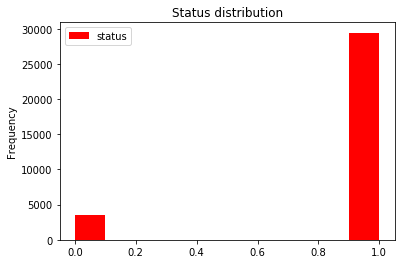

In [233]:
df.plot(y='status', kind='hist', 
           color='red',  title='Status distribution')

### Кросс-валидация

##### Также по причине дисбаланса классов, был выбран метод кросс-валидации StratifiedKFold, который позволяет сохранять баланс при разбиении.

In [234]:
from sklearn.model_selection import StratifiedKFold

### Алгоритмы

##### Для решения задачи было выбрано пять алгоритмов классификации: k ближайших соседей, логистическая регрессия, метод опорных векторов, деревья решений, случайный лес.

In [235]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Построение алгоритмов без стандартизации данных. 

In [236]:
columns_to_change = list(df)[1:-1]

for line in range(0, len(columns_to_change)):
    N = len(df[columns_to_change[line]])
    for i in range(0, N):
        if isinstance(df[columns_to_change[line]].values[i], str):
            df[columns_to_change[line]].values[i]=float(df[columns_to_change[line]].values[i].replace('%','').replace(',','.').replace(' ',''))  

In [237]:
X = df.drop('status', 1)
y = df['status']

In [238]:
X1 = X.values
y1 = y.values

In [239]:
knn = KNeighborsClassifier() 
LogRes = LogisticRegression()
DTC = DecisionTreeClassifier()
RandomRC = RandomForestClassifier()

kf = StratifiedKFold(n_splits=20)

In [241]:
algorithms = [(knn, 'KNeighbors'), (LogRes, 'LogisticRegression'), (DTC, 'DecisionTree'), 
              (RandomRC, 'RandomForest')]
all_score = []
for algorithm, algorithm_name in algorithms:
    for train_indices, test_indices in kf.split(X1, y1):
        X_train, X_test = X1[train_indices], X1[test_indices]
        y_train, y_test = y1[train_indices], y1[test_indices]
        clf = algorithm.fit(X_train, y_train)
        y_test_predict = clf.predict(X_test)
        score = roc_auc_score(y_test, y_test_predict)
        all_score.append(score)
        
    mean_scor = np.mean(all_score)
    print(f'ROC-AUC:{mean_scor} для алгоритма {algorithm_name}')

ROC-AUC:0.8558090092855553 для алгоритма KNeighbors
ROC-AUC:0.6818409821498627 для алгоритма LogisticRegression
ROC-AUC:0.7859905210706766 для алгоритма DecisionTree
ROC-AUC:0.826987586040295 для алгоритма RandomForest


### Построение алгоритмов с учетом стардантизарции данных.

In [242]:
def learning(scaler):
    algorithms = [(knn, 'KNeighbors'), (LogRes, 'LogisticRegression'), (DTC, 'DecisionTree'), 
              (RandomRC, 'RandomForest')]
    all_score = []
    for algorithm, algorithm_name in algorithms:
        for train_indices, test_indices in kf.split(X1, y1):
            X_train, X_test = X1[train_indices], X1[test_indices]
            y_train, y_test = y1[train_indices], y1[test_indices]
            scaled_X_train = scaler.fit_transform(X_train)
            scaled_X_test = scaler.fit_transform(X_test)
            clf = algorithm.fit(scaled_X_train, y_train)
            y_test_predict = clf.predict(scaled_X_test)
            score = roc_auc_score(y_test, y_test_predict)
            all_score.append(score)
        
        mean_scor = np.mean(all_score)
        print(f'ROC-AUC:{mean_scor} для алгоритма {algorithm_name}')

### StandardScaler

In [245]:
learning(StandardScaler())

ROC-AUC:0.8486696079039833 для алгоритма KNeighbors
ROC-AUC:0.7532163156835137 для алгоритма LogisticRegression
ROC-AUC:0.8263392862132515 для алгоритма DecisionTree
ROC-AUC:0.842464716857459 для алгоритма RandomForest


### MinMaxScaler

In [246]:
learning(MinMaxScaler())

ROC-AUC:0.7530472802919218 для алгоритма KNeighbors
ROC-AUC:0.7606285452194249 для алгоритма LogisticRegression
ROC-AUC:0.6692742783283075 для алгоритма DecisionTree
ROC-AUC:0.6918116186883985 для алгоритма RandomForest


### MaxAbsScaler

In [247]:
learning(MinMaxScaler())

ROC-AUC:0.7530472802919218 для алгоритма KNeighbors
ROC-AUC:0.7606285452194249 для алгоритма LogisticRegression
ROC-AUC:0.6692742783283075 для алгоритма DecisionTree
ROC-AUC:0.6913853477645138 для алгоритма RandomForest


##### Для повышения качества алгоритмов стоит создать признаки, которые будут отражать динамику показателей. В таком случае есть смысл присваивать первый класс только для последних месяцев функционирования банков. Но тогда дисбаланс классов станет ещё более явным, что можно попробовать решить с помощью методов: undersampling или oversampling.